# Задача: Ансамбли. Лямин Владимир Андреевич. Группа 22.М05

Задача
1. Найти данные размера хотя бы 10000, на которых можно решить задачу классификации или регрессии.

2. Выполнить разведочный анализ (EDA). При необходимости выполнить полезные преобразования данных.

3. Самостоятельно реализуйте алгоритмы Bagging и AdaBoost, которые позволят обучить ансамбли каких-то простых моделей, например деревьев принятия решений.

4. Обучите ансамбли для каких-то простых моделей, используя свои две реализации, а также реализации из sklearn (Bagging, Random Forest, AdaBoost, Gradient Tree Boosting, Histogram-Based Gradient Boosting).

5. При обучении использовать подбор гиперпараметров, кросс-валидацию.

6. Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества, построить матрицы ошибок.

7. (+2 балла) Также добавить в сравнение модели из библиотек XGBoost, LightGBM и CatBoost.

8. (+3 балла) Для подбора гиперпараметров использовать фреймворк Optuna.


Рассмотрим датасет по стоимости жилья, затем сделаем из него подходящий датасет для задачи по многоклассовой классификации по данному руководству(https://medium.com/dataman-in-ai/a-wide-choice-for-modeling-multi-class-classifications-d97073ff4ec8).

Описание датасета:
1. MedInc: средний доход в квартале
2. house: средний возраст домов в квартале
3. AveRooms: среднее количество комнат на дом
4. AveBedrms: среднее количество спален на дом
5. Population: популяция квартала
6. AveOccup: среднее количество жителей дома
7. Latitude: широта квартала
8. Longitude: долгота квартала

Необходимо решить задачу классификации и научиться предсказывать целовой признак target. Среднюю стоимость дома в квартале.

In [100]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
%matplotlib inline
import seaborn as sns

# устанавливаем точность чисел с плавающей точкой
%precision %.4f

import warnings
warnings.filterwarnings('ignore')  # отключаем предупреждения

In [101]:
cal_housing = fetch_california_housing()
X = pd.DataFrame(cal_housing.data, columns=cal_housing.feature_names)
y = cal_housing.target
df = X.copy()
df['target'] = y * 100000 # The raw value is in 100,000.
X_features = cal_housing.feature_names
print("X features=", X_features)

X features= ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [102]:
df.to_csv('Houses.csv')

In [103]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,452600.0
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,358500.0
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,352100.0
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,341300.0
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,342200.0


Проверяем общее количество пропущенных значений.


In [104]:
df.isnull().sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
target        0
dtype: int64

Как видно, пропущенных значений нет

In [105]:
def val_target(y):    
    if y <= 160000:
        return 0
    else:
        return 1
    
df['target_class'] = df['target'].apply(val_target)

In [106]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target,target_class
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,452600.0,1
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,358500.0,1
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,352100.0,1
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,341300.0,1
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,342200.0,1


Разделили данные на два класса: низкая и высокая стоимость дома.

## Разведочный анализ (EDA)

Посмортим какие значения принимает целевой признак

In [107]:
df.target_class.value_counts()

1    12101
0     8539
Name: target_class, dtype: int64

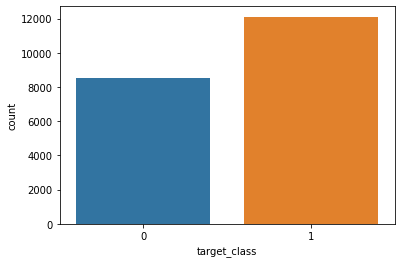

In [108]:
sns.countplot(x="target_class", data=df)
plt.show()


Можно заметить, что получившиеся классы сравнимы

## Певичный анализ признаков

### Количесвенный признак MedInc

Посмотрим какие значения принимает данный признак


In [109]:
df['MedInc'].describe()


count    20640.000000
mean         3.870671
std          1.899822
min          0.499900
25%          2.563400
50%          3.534800
75%          4.743250
max         15.000100
Name: MedInc, dtype: float64

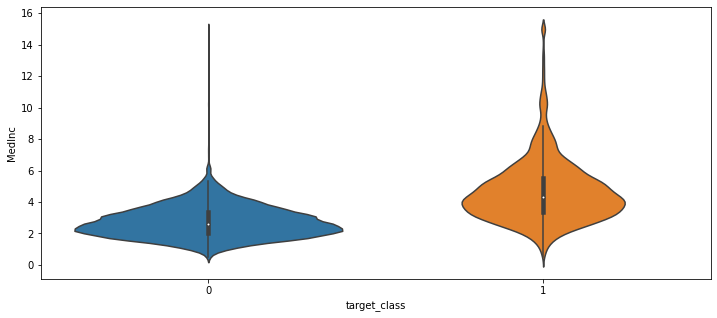

In [110]:
sns.violinplot(data=df,x="target_class", y='MedInc', split=True)
fig = plt.gcf()
fig.set_size_inches(12, 5)
plt.show()

Можно заметить, что чем выше доход житеелей квартала, тем более высокая стоимость домов

### Количесвенный признак HouseAge


In [111]:
df['HouseAge'].describe()

count    20640.000000
mean        28.639486
std         12.585558
min          1.000000
25%         18.000000
50%         29.000000
75%         37.000000
max         52.000000
Name: HouseAge, dtype: float64

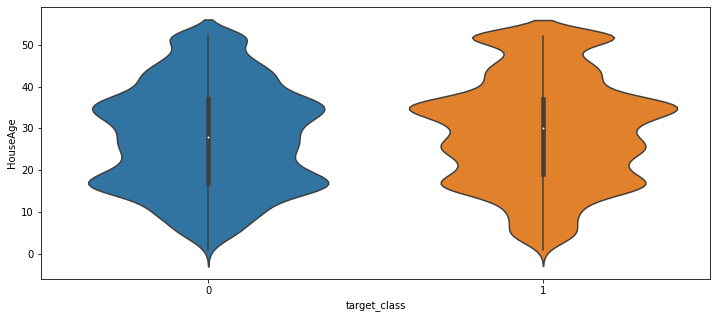

In [112]:
sns.violinplot(data=df,x="target_class", y='HouseAge', split=True)
fig = plt.gcf()
fig.set_size_inches(12, 5)
plt.show()


Можно заметить, что возраст дома на стоимость влияет слабо

### Количесвенный признак AveRooms

In [113]:
df['AveRooms'].describe()

count    20640.000000
mean         5.429000
std          2.474173
min          0.846154
25%          4.440716
50%          5.229129
75%          6.052381
max        141.909091
Name: AveRooms, dtype: float64

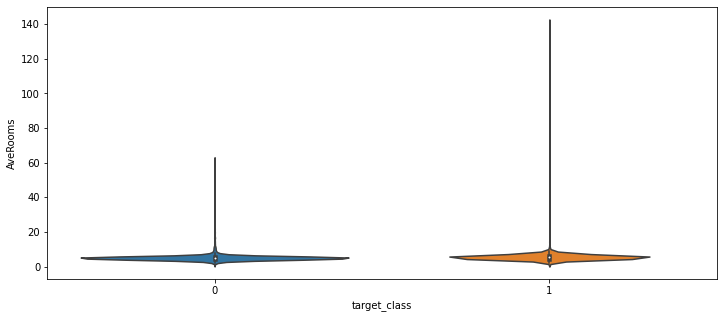

In [114]:
sns.violinplot(data=df,x="target_class", y='AveRooms', split=True)
fig = plt.gcf()
fig.set_size_inches(12, 5)
plt.show()


Тут можно заметить, что при увеличении комнат стоимость дома увеличивается.

### Количесвенный признак Population

In [115]:
df['Population'].describe()

count    20640.000000
mean      1425.476744
std       1132.462122
min          3.000000
25%        787.000000
50%       1166.000000
75%       1725.000000
max      35682.000000
Name: Population, dtype: float64

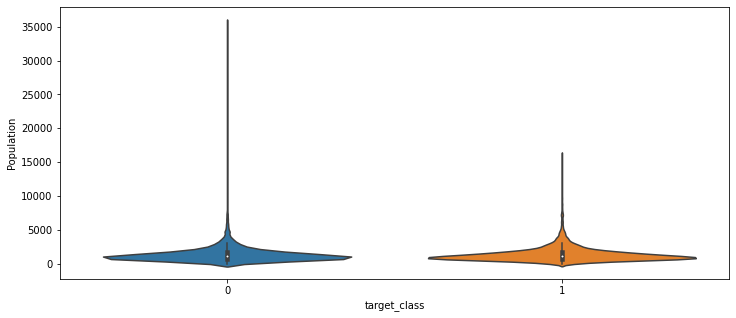

In [116]:
sns.violinplot(data=df,x="target_class", y='Population', split=True)
fig = plt.gcf()
fig.set_size_inches(12, 5)
plt.show()


Тут можно заметить, что численность района на стоимость жилья влияет слабо. 

### Количесвенный признак AveOccup

In [117]:
df['AveOccup'].describe()

count    20640.000000
mean         3.070655
std         10.386050
min          0.692308
25%          2.429741
50%          2.818116
75%          3.282261
max       1243.333333
Name: AveOccup, dtype: float64

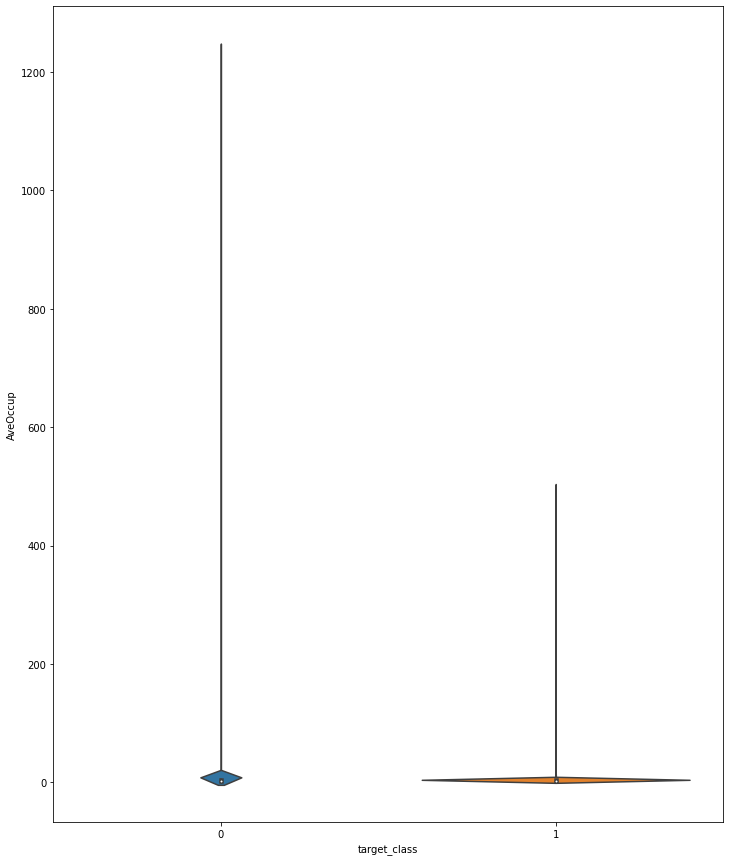

In [118]:
sns.violinplot(data=df,x="target_class", y='AveOccup', split=True)
fig = plt.gcf()
fig.set_size_inches(12, 15)
plt.show()

Можно заметить, что чем дороже дом, тем меньше средняя численость его жителей

### Количесвенный признак Latitude

In [119]:
df['Latitude'].describe()

count    20640.000000
mean        35.631861
std          2.135952
min         32.540000
25%         33.930000
50%         34.260000
75%         37.710000
max         41.950000
Name: Latitude, dtype: float64

## Feature Engineering

Заменем количесвенные вещественные признаки категориальными. Будем распределять по классам с примерно одинаковой численностью

In [120]:
def val_target(y):
    if y<=1:
        return 0
    elif y<=2:
        return 1
    elif y<=3:
        return 2
    else:
        return 3
    
df['MedInc_class'] = df['MedInc'].apply(val_target)

In [121]:
def val_target(y):
    if y<=2:
        return 0
    elif y<=3:
        return 1
    elif y<=4:
        return 2
    else:
        return 3
    
df['AveRooms_class'] = df['AveRooms'].apply(val_target)

In [122]:
def val_target(y):
    if y<=1:
        return 0
    elif y<=2:
        return 1
    else:
        return 2
    
df['AveBedrms_class'] = df['AveBedrms'].apply(val_target)

In [123]:
def val_target(y):
    if y<=2:
        return 0
    elif y<=3:
        return 1
    elif y<=4:
        return 2
    else:
        return 3
    
df['AveOccup_class'] = df['AveOccup'].apply(val_target)

In [124]:
def val_target(y):
    if y<=33:
        return 0
    elif y<=34:
        return 1
    elif y<=37:
        return 2
    else:
        return 3
    
df['Latitude_class'] = df['Latitude'].apply(val_target)

## Удаление ненужных признаков

Так как мы ввели новый признак target_class, то можно удалить признак target

In [125]:
df.drop(['target'], axis=1, inplace=True)

Также удаляем вещественные признаки, которые мы заменили категориальными

In [126]:
# Удаляем количественные признаки, которые преобразовали в категориальные.
df.drop(['MedInc', 'AveRooms', 'AveBedrms', 'AveOccup', 'Latitude'], axis = 1, inplace = True)

## Посмотрим корреляцию данных


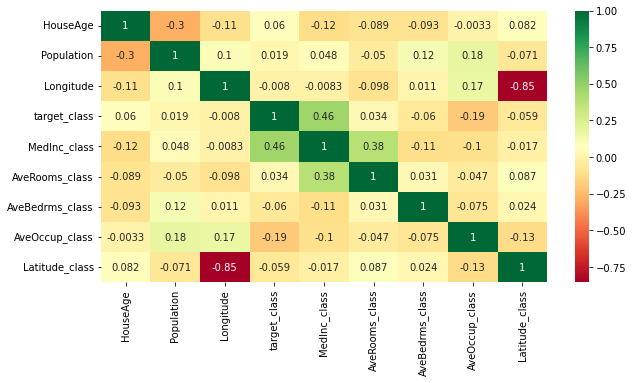

In [127]:
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn')
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()

Можно заметить, что Latitude и Longitude сильно коррелируют. Поэтому можно удалить одну из них.

## Разбиение данных

Разобъем данные на тестовую выборку и обучающую

In [128]:
from sklearn.model_selection import train_test_split

y = df["target_class"]
X = df.drop(columns=["target_class"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Проверим, что мы получили то, что хотели

In [129]:
df.head()

,HouseAge,Population,Longitude,target_class,MedInc_class,AveRooms_class,AveBedrms_class,AveOccup_class,Latitude_class
0,41.0,322.0,-122.23,1,3,3,1,1,3
1,21.0,2401.0,-122.22,1,3,3,0,1,3
2,52.0,496.0,-122.24,1,3,3,1,1,3
3,52.0,558.0,-122.25,1,3,3,1,1,3
4,52.0,565.0,-122.25,1,3,3,1,1,3


In [130]:
df.drop(['Longitude'], axis=1, inplace=True)

## Реализация алгоритмов

### Реализуем алгоритм AdaBoost

In [131]:
def compute_error(y, y_pred, w_i):
    return (sum(w_i * (np.not_equal(y, y_pred)).astype(int)))/sum(w_i)

In [132]:
def compute_alpha(error):
    return np.log((1 - error) / error)

In [133]:
def update_weights(w_i, alpha, y, y_pred):
    return w_i * np.exp(alpha * (np.not_equal(y, y_pred)).astype(int))

In [134]:
from sklearn.tree import DecisionTreeClassifier


class MyAdaBoostClassifier:
    
    def __init__(self, M = 20):
        self.alphas = []
        self.G_M = []
        self.M = M
        self.training_errors = []
        self.prediction_errors = []

    def fit(self, X, y):
        
        self.alphas = [] 
        self.training_errors = []

        for m in range(0, self.M):
            if m == 0:
                w_i = np.ones(len(y)) * 1 / len(y)
            else:
                w_i = update_weights(w_i, alpha_m, y, y_pred)
            
            G_m = DecisionTreeClassifier(max_depth = 1)
            G_m.fit(X, y, sample_weight = w_i)
            y_pred = G_m.predict(X)
            
            self.G_M.append(G_m)

            error_m = compute_error(y, y_pred, w_i)
            self.training_errors.append(error_m)

            alpha_m = compute_alpha(error_m)
            self.alphas.append(alpha_m)

        assert len(self.G_M) == len(self.alphas)
        
    def predict(self, X):
        weak_preds = pd.DataFrame(index = range(len(X)), columns = range(self.M)) 

        for m in range(self.M):
            y_pred_m = self.G_M[m].predict(X) * self.alphas[m]
            weak_preds.iloc[:,m] = y_pred_m

        y_pred = (1 * np.sign(weak_preds.T.sum())).astype(int)

        return y_pred

In [135]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.5894702842377261

In [137]:
from sklearn.metrics import accuracy_score
import time
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    estimators_number = trial.suggest_int('Estimators number', 1, 25)
    
    model = MyAdaBoostClassifier(estimators_number)
    model.fit(np.array(X_train), np.array(y_train))
    y_pred = model.predict(np.array(X_test))

    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials = n_trials)

print(f'Best parameters: {study.best_trial.params}')
print(f'Best accuracy: {study.best_value}')

estimators_number_best = study.best_trial.params['Estimators number']

model = MyAdaBoostClassifier(estimators_number_best)

start = time.time()
model.fit(X_train, y_train)
end = time.time()

MyAdaboost_predClassifier = model.predict(X_test)
MyAdaboostClassifier_accuracy = accuracy_score(y_test, MyAdaboost_predClassifier)
MyAdaboostClassifier_time = end - start

print(f'Model accuracy: {MyAdaboostClassifier_accuracy}')
print(f'Model time: {MyAdaboostClassifier_time}')

Best parameters: {'Estimators number': 1}
Best accuracy: 0.7464470284237726
Model accuracy: 0.7464470284237726
Model time: 0.01599597930908203


### Реализуем алгоритм Bagging 

In [138]:
class MyBaggingClassifier:
    def __init__(self, estimators_number = 15, samples_number = 1):
        self.estimators_number = estimators_number
        self.samples_number = samples_number

    def fit(self, x, y):
        self.estimators = []
        
        for i in range(self.estimators_number):
            sample_index = np.random.choice(self.samples_number, size = len(x))
            x_sample = x[sample_index]
            y_sample = y[sample_index]
            
            estimator = DecisionTreeClassifier()
            estimator.fit(x_sample, y_sample)

            self.estimators.append(estimator)

    def predict(self, x):
        predicted = np.zeros(len(x))
        for estimator in self.estimators:
            predicted += estimator.predict(x)
        
        return np.round(predicted / self.estimators_number)

In [139]:
accuracy= [] 
recall =[]
roc_auc= []
precision = []
times = []

model_names =[]

n_trials = 30

In [140]:
def objective(trial):
    estimators_number = trial.suggest_int('n_estimators', 10, 25)
    samples_number = trial.suggest_int('n_samples', 30, 50)
    
    model = MyBaggingClassifier(estimators_number, samples_number)
    model.fit(np.array(X_train), np.array(y_train))
    y_pred = model.predict(np.array(X_test))

    return accuracy_score(y_test, y_pred)


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials = n_trials)


print(f'Best parameters: {study.best_trial.params}')
print(f'Best accuracy: {study.best_value}')

estimators_number_best = study.best_trial.params['n_estimators']
samples_number_best = study.best_trial.params['n_samples']

model = MyBaggingClassifier(estimators_number_best, samples_number_best)

start = time.time()
model.fit(np.array(X_train), np.array(y_train))
end = time.time()

MybaggingClassifier_pred = model.predict(X_test)
MybaggingClassifier_accuracy = accuracy_score(y_test, MybaggingClassifier_pred)
MybaggingClassifier_time = end - start

print(f'Model accuracy: {MybaggingClassifier_accuracy}')
print(f'Model time: {MybaggingClassifier_time}')

Best parameters: {'n_estimators': 15, 'n_samples': 49}
Best accuracy: 0.688953488372093
Model accuracy: 0.6824935400516796
Model time: 0.25184130668640137


## Обучение библиотечных моделей из sklearn 


### AdaBoost

In [142]:
from sklearn.ensemble import AdaBoostClassifier

def objective(trial):
    estimators_number = trial.suggest_int('Estimators number', 1, 10)
    learning_rate = trial.suggest_int('Learning rate', 1, 5)
    
    model = AdaBoostClassifier(
        n_estimators = estimators_number,
        learning_rate = learning_rate / 10,
        base_estimator = DecisionTreeClassifier())
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = n_trials)

print(f'Best parameters: {study.best_trial.params}')
print(f'Best accuracy: {study.best_value}')

estimators_number_best = study.best_trial.params['Estimators number']
learning_rate_best = study.best_trial.params['Learning rate']

model = AdaBoostClassifier(
    n_estimators = estimators_number_best,
    learning_rate = learning_rate_best / 10,
    base_estimator = DecisionTreeClassifier())

start = time.time()
model.fit(X_train, y_train)
end = time.time()

sklearn_adaboostClassifier_pred = model.predict(X_test)
sklearn_adaboostClassifier_accuracy = accuracy_score(y_test, sklearn_adaboostClassifier_pred)
sklearn_adaboostClassifier_time = end - start

print(f'Model accuracy: {sklearn_adaboostClassifier_accuracy}')
print(f'Model time: {sklearn_adaboostClassifier_time}')

Best parameters: {'Estimators number': 9, 'Learning rate': 4}
Best accuracy: 0.7877906976744186
Model accuracy: 0.7860142118863049
Model time: 0.12099766731262207


### Bagging

In [157]:
from sklearn.ensemble import BaggingClassifier

def objective(trial):
    estimators_number = trial.suggest_int('Estimators number', 1, 25)
    samples_number = trial.suggest_int('Samples number', 1, 20)
    features_number = trial.suggest_int('Features number', 2, 10)
    model = BaggingClassifier(
        n_estimators = estimators_number,
        max_samples = samples_number / 20,
        max_features = features_number / 10,
        base_estimator = DecisionTreeClassifier())
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = n_trials)

print(f'Best parameters: {study.best_trial.params}')
print(f'Best accuracy: {study.best_value}')

estimators_number_best = study.best_trial.params['Estimators number']
samples_number_best = study.best_trial.params['Samples number']
features_number_best = study.best_trial.params['Features number']

model = BaggingClassifier(
    n_estimators = estimators_number_best,
    max_samples = samples_number_best / 20,
    max_features = features_number_best / 12,
    base_estimator = DecisionTreeClassifier())

start = time.time()
model.fit(X_train, y_train)
end = time.time()

sklearn_baggingClassifier_pred = model.predict(X_test)
sklearn_baggingClassifier_accuracy = accuracy_score(y_test, sklearn_baggingClassifier_pred)
sklearn_baggingClassifier_time = end - start

print(f'Model accuracy: {sklearn_baggingClassifier_accuracy}')
print(f'Model time: {sklearn_baggingClassifier_time}')

Best parameters: {'Estimators number': 25, 'Samples number': 14, 'Features number': 8}
Best accuracy: 0.8417312661498708
Model accuracy: 0.8292958656330749
Model time: 0.45031118392944336


### Random Forest

In [144]:
from sklearn.ensemble import RandomForestClassifier

def objective(trial):
    estimators_number = trial.suggest_int('Estimators number', 1, 100)
    samples_number = trial.suggest_int('Samples number', 1, 20)
    features_number = trial.suggest_int('Features number', 2, 10)
    rf = RandomForestClassifier(
        n_estimators = estimators_number,
        max_samples = samples_number / 30,
        max_features = features_number / 10,
        max_depth = 4,
        random_state = 40)
    
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = n_trials)

print(f'Best parameters: {study.best_trial.params}')
print(f'Best accuracy: {study.best_value}')

estimators_number_best = study.best_trial.params['Estimators number']
samples_number_best = study.best_trial.params['Samples number']
features_number_best = study.best_trial.params['Features number']

model = RandomForestClassifier(
    n_estimators = estimators_number_best,
    max_samples = samples_number_best / 30,
    max_features = features_number_best / 10,
    max_depth = 4,
    random_state = 42)

start = time.time()
model.fit(X_train, y_train)
end = time.time()

sklearn_RandomForestClassifier_pred = model.predict(X_test)
sklearn_RandomForestClassifier_accuracy = accuracy_score(y_test, sklearn_RandomForestClassifier_pred)
sklearn_RandomForestClassifier_time = end - start

print(f'Model accuracy: {sklearn_RandomForestClassifier_accuracy}')
print(f'Model time: {sklearn_RandomForestClassifier_time}')

Best parameters: {'Estimators number': 19, 'Samples number': 16, 'Features number': 10}
Best accuracy: 0.790859173126615
Model accuracy: 0.790859173126615
Model time: 0.29399609565734863


### Gradient Tree Boosting

In [145]:
from sklearn.ensemble import GradientBoostingClassifier

def objective(trial):
    estimators_number = trial.suggest_int('Estimators number', 1, 25)
    depth = trial.suggest_int('Depth', 1, 10)
    features_number = trial.suggest_int('Features number', 2, 10)
    gb = GradientBoostingClassifier(
        n_estimators = estimators_number,
        max_depth = depth,
        max_features = features_number / 10,
        random_state = 40)
    
    gb.fit(X_train, y_train)
    y_pred = gb.predict(X_test)

    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = n_trials)

print(f'Best parameters: {study.best_trial.params}')
print(f'Best accuracy: {study.best_value}')

estimators_number_best = study.best_trial.params['Estimators number']
depth_best = study.best_trial.params['Depth']
features_number_best = study.best_trial.params['Features number']

model = GradientBoostingClassifier(
    n_estimators = estimators_number_best,
    max_depth = depth_best,
    max_features = features_number_best / 10,
    random_state = 42)

start = time.time()
model.fit(X_train, y_train)
end = time.time()

sklearn_GradientBoostingClassifier_pred = model.predict(X_test)
sklearn_GradientBoostingClassifier_accuracy = accuracy_score(y_test, sklearn_GradientBoostingClassifier_pred)
sklearn_GradientBoostingClassifier_time = end - start

print(f'Model accuracy: {sklearn_GradientBoostingClassifier_accuracy}')
print(f'Model time: {sklearn_GradientBoostingClassifier_time}')

Best parameters: {'Estimators number': 25, 'Depth': 10, 'Features number': 7}
Best accuracy: 0.8488372093023255
Model accuracy: 0.8488372093023255
Model time: 1.884943962097168


### Histogram-Based Gradient Boosting

In [146]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

def objective(trial):
    learning_rate = trial.suggest_int('Learning rate', 1, 10)
    iterations_number = trial.suggest_int('Iterations number', 1, 15)
    leaf_nodes_number = trial.suggest_int('Leaf nodes number', 2, 32)
    depth = trial.suggest_int('Depth', 1, 10)
    hgb = HistGradientBoostingClassifier(
        learning_rate = learning_rate / 10,
        max_iter = iterations_number,
        max_depth = depth,
        max_leaf_nodes = leaf_nodes_number,
        random_state = 40)
    
    hgb.fit(X_train, y_train)
    y_pred = hgb.predict(X_test)

    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = n_trials)

print(f'Best parameters: {study.best_trial.params}')
print(f'Best accuracy: {study.best_value}')

learning_rate_best = study.best_trial.params['Learning rate']
iterations_number_best = study.best_trial.params['Iterations number']
depth_best = study.best_trial.params['Depth']
leaf_nodes_number_best = study.best_trial.params['Leaf nodes number']

model = HistGradientBoostingClassifier(
    learning_rate = learning_rate_best / 10,
    max_iter = iterations_number_best,
    max_depth = depth_best,
    max_leaf_nodes = leaf_nodes_number_best,
    random_state = 42)

start = time.time()
model.fit(X_train, y_train)
end = time.time()

sklearn_HistGradientBoostingClassifier_pred = model.predict(X_test)
sklearn_HistGradientBoostingClassifier_accuracy = accuracy_score(y_test, sklearn_HistGradientBoostingClassifier_pred)
sklearn_HistGradientBoostingClassifier_time = end - start

print(f'Model accuracy: {sklearn_HistGradientBoostingClassifier_accuracy}')
print(f'Model time: {sklearn_HistGradientBoostingClassifier_time}')

Best parameters: {'Learning rate': 6, 'Iterations number': 11, 'Leaf nodes number': 25, 'Depth': 7}
Best accuracy: 0.8401162790697675
Model accuracy: 0.8401162790697675
Model time: 0.17900300025939941


## Дополнительные модели

## xgboost

In [147]:
from xgboost import XGBClassifier

def objective(trial):
    estimators_number = trial.suggest_int('Estimators number', 1, 25)
    leaves_number = trial.suggest_int('Leaves number', 1, 20)
    depth = trial.suggest_int('Depth', 1, 10)
    xgb = XGBClassifier(
        n_estimators = estimators_number,
        max_leaves = leaves_number,
        max_depth = depth,
        random_state = 40)
    
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)

    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = n_trials)

print(f'Best parameters: {study.best_trial.params}')
print(f'Best accuracy: {study.best_value}')

estimators_number_best = study.best_trial.params['Estimators number']
leaves_number_best = study.best_trial.params['Leaves number']
depth_best = study.best_trial.params['Depth']

model = XGBClassifier(
    n_estimators = estimators_number_best,
    max_leaves = leaves_number_best,
    max_depth = depth_best,
    random_state = 42)

start = time.time()
model.fit(X_train, y_train)
end = time.time()

xgboostClassifier_pred = model.predict(X_test)
xgboostClassifier_accuracy = accuracy_score(y_test, xgboostClassifier_pred)
xgboostClassifier_time = end - start

print(f'Model accuracy: {xgboostClassifier_accuracy}')
print(f'Model time: {xgboostClassifier_time}')

Best parameters: {'Estimators number': 21, 'Leaves number': 3, 'Depth': 8}
Best accuracy: 0.8460917312661499
Model accuracy: 0.8460917312661499
Model time: 0.33608078956604004


### lightgbm

In [148]:
from lightgbm import LGBMClassifier

def objective(trial):
    estimators_number = trial.suggest_int('Estimators number', 1, 25)
    learning_rate = trial.suggest_int('Learning rate', 1, 10)
    depth = trial.suggest_int('Depth', 1, 10)
    xgb = LGBMClassifier(
        n_estimators = estimators_number,
        learning_rate = learning_rate / 10,
        max_depth = depth,
        random_state = 40)
    
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)

    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = n_trials)

print(f'Best parameters: {study.best_trial.params}')
print(f'Best accuracy: {study.best_value}')

estimators_number_best = study.best_trial.params['Estimators number']
learning_rate_best = study.best_trial.params['Learning rate']
depth_best = study.best_trial.params['Depth']

model = LGBMClassifier(
    n_estimators = estimators_number_best,
    learning_rate = learning_rate_best / 10,
    max_depth = depth_best,
    random_state = 42)

start = time.time()
model.fit(X_train, y_train)
end = time.time()

lightgbmClassifier_pred = model.predict(X_test)
lightgbmClassifier_accuracy = accuracy_score(y_test, lightgbmClassifier_pred)
lightgbmClassifier_time = end - start

print(f'Model accuracy: {lightgbmClassifier_accuracy}')
print(f'Model time: {lightgbmClassifier_time}')

Best parameters: {'Estimators number': 12, 'Learning rate': 4, 'Depth': 8}
Best accuracy: 0.838016795865633
Model accuracy: 0.838016795865633
Model time: 0.06599926948547363


### catboost

In [149]:
from catboost import CatBoostClassifier

def objective(trial):
    estimators_number = trial.suggest_int('Estimators number', 1, 25)
    learning_rate = trial.suggest_int('Learning rate', 1, 10)
    depth = trial.suggest_int('Depth', 1, 10)
    xgb = CatBoostClassifier(
        n_estimators = estimators_number,
        learning_rate = learning_rate / 10,
        max_depth = depth,
        random_state = 40,
        verbose = False)
    
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)

    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = n_trials)

print(f'Best parameters: {study.best_trial.params}')
print(f'Best accuracy: {study.best_value}')

estimators_number_best = study.best_trial.params['Estimators number']
learning_rate_best = study.best_trial.params['Learning rate']
depth_best = study.best_trial.params['Depth']

model = CatBoostClassifier(
    n_estimators = estimators_number_best,
    learning_rate = learning_rate_best / 10,
    max_depth = depth_best,
    random_state = 42,
    verbose = False)

start = time.time()
model.fit(X_train, y_train)
end = time.time()

catboostClassifier_pred = model.predict(X_test)
catboostClassifier_accuracy = accuracy_score(y_test, catboostClassifier_pred)
catboostClassifier_time = end - start

print(f'Model accuracy: {catboostClassifier_accuracy}')
print(f'Model time: {catboostClassifier_time}')

Best parameters: {'Estimators number': 21, 'Learning rate': 9, 'Depth': 6}
Best accuracy: 0.8439922480620154
Model accuracy: 0.8439922480620154
Model time: 0.19899797439575195


## Выводы


### Промежуточные выводы о точности методов и стратегий

In [153]:
table = {
    'methods\Characteristics': ['Accuracy', 'Time'],
    'MyAdaBoost':[MyAdaboostClassifier_accuracy, MyAdaboostClassifier_time],
    'MyBagging': [MybaggingClassifier_accuracy, MybaggingClassifier_time],
    'Bagging': [sklearn_baggingClassifier_accuracy, sklearn_baggingClassifier_time],
    'Random Forest': [sklearn_RandomForestClassifier_accuracy, sklearn_RandomForestClassifier_time],
    'AdaBoost':[sklearn_adaboostClassifier_accuracy, sklearn_adaboostClassifier_time],
    'Gradient Tree Boosting': [sklearn_GradientBoostingClassifier_accuracy, sklearn_GradientBoostingClassifier_time],
    'Histogram-Based Gradient Boosting': [sklearn_HistGradientBoostingClassifier_accuracy, sklearn_HistGradientBoostingClassifier_time],
    'XGBoost': [xgboostClassifier_accuracy, xgboostClassifier_time],
    'LightGBM ':[lightgbmClassifier_accuracy, lightgbmClassifier_time],
    'CatBoost': [catboostClassifier_accuracy, catboostClassifier_time],
}

pd.DataFrame(data=table)

,methods\Characteristics,MyAdaBoost,MyBagging,Bagging,Random Forest,AdaBoost,Gradient Tree Boosting,Histogram-Based Gradient Boosting,XGBoost,LightGBM,CatBoost
0,Accuracy,0.746447,0.682494,0.842862,0.790859,0.786014,0.848837,0.840116,0.846092,0.838017,0.843992
1,Time,0.015996,0.251841,0.932002,0.293996,0.120998,1.884944,0.179003,0.336081,0.065999,0.198998


Можно заметить, что если рассматривать только качество алгоритма, то лучшими являются сразу несколько: XGBoost, Histogram-Based Gradient Boosting, MyAdaBoost, CatBoost. Но если рассматривать еще и время, то остается три алгоритма: Histogram-Based Gradient Boosting, LightGBM и MyAdaBoost.

### Построение Confusion Matrix

In [159]:
from sklearn.metrics import confusion_matrix

cm_MyAda = confusion_matrix(y_test, MyAdaboost_predClassifier)
cm_MyBag = confusion_matrix(y_test, MybaggingClassifier_pred)
cm_Bag = confusion_matrix(y_test, sklearn_baggingClassifier_pred)
cm_RandomForest = confusion_matrix(y_test, sklearn_RandomForestClassifier_pred)
cm_Ada = confusion_matrix(y_test, sklearn_adaboostClassifier_pred)
cm_Gradient = confusion_matrix(y_test, sklearn_GradientBoostingClassifier_pred)
cm_HistGradient = confusion_matrix(y_test, sklearn_HistGradientBoostingClassifier_pred)
cm_xgboost = confusion_matrix(y_test, xgboostClassifier_pred)
cm_lightgbm = confusion_matrix(y_test, lightgbmClassifier_pred)
cm_catboost = confusion_matrix(y_test, catboostClassifier_pred)

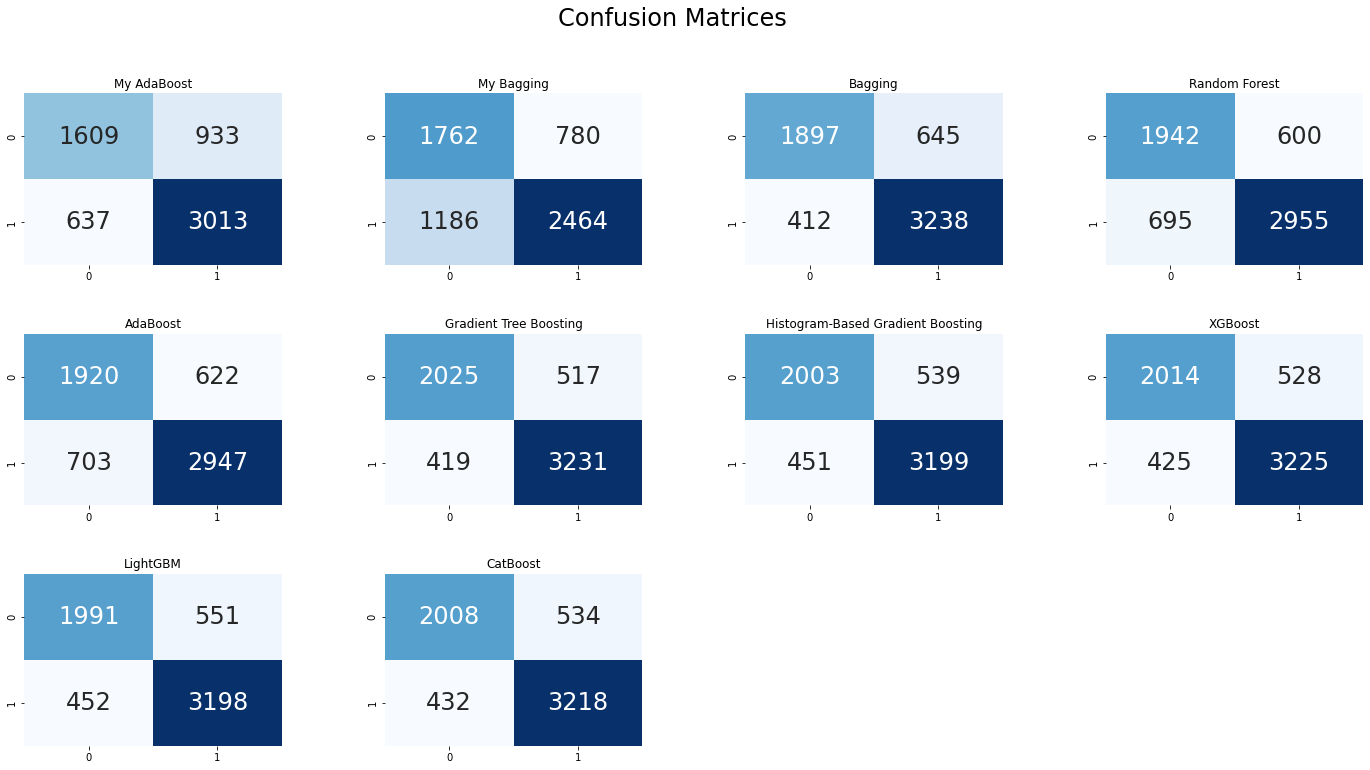

In [165]:
plt.figure(figsize=(24, 12))

plt.suptitle("Confusion Matrices", fontsize=24)
plt.subplots_adjust(wspace = 0.4, hspace= 0.4)

plt.subplot(3,4,1)
plt.title("My AdaBoost")
sns.heatmap(cm_MyAda,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,4,2)
plt.title("My Bagging")
sns.heatmap(cm_MyBag,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,4,3)
plt.title("Bagging")
sns.heatmap(cm_Bag,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,4,4)
plt.title("Random Forest")
sns.heatmap(cm_RandomForest,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,4,5)
plt.title("AdaBoost")
sns.heatmap(cm_Ada,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,4,6)
plt.title("Gradient Tree Boosting")
sns.heatmap(cm_Gradient,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,4,7)
plt.title("Histogram-Based Gradient Boosting")
sns.heatmap(cm_HistGradient,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,4,8)
plt.title("XGBoost")
sns.heatmap(cm_xgboost,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,4,9)
plt.title("LightGBM")
sns.heatmap(cm_lightgbm,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,4,10)
plt.title("CatBoost")
sns.heatmap(cm_catboost,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.show()

## Выводы

На матрицах ошибок можно заметить, что все модели дают примерно однаковое количество ошибок первого и второго рода. В прошлым выводам можно прибавить, что наиболее худшей моделью является My Bagging.